Fiziksel anten boyutu: 0.1 m
Işın genişliği: 17.19°
Sentetik aperture uzunluğu: 300.0 m
SAR çözünürlüğü: 0.05 m
Geleneksel radar çözünürlüğü: 300.0 m
İyileşme faktörü: 6000x


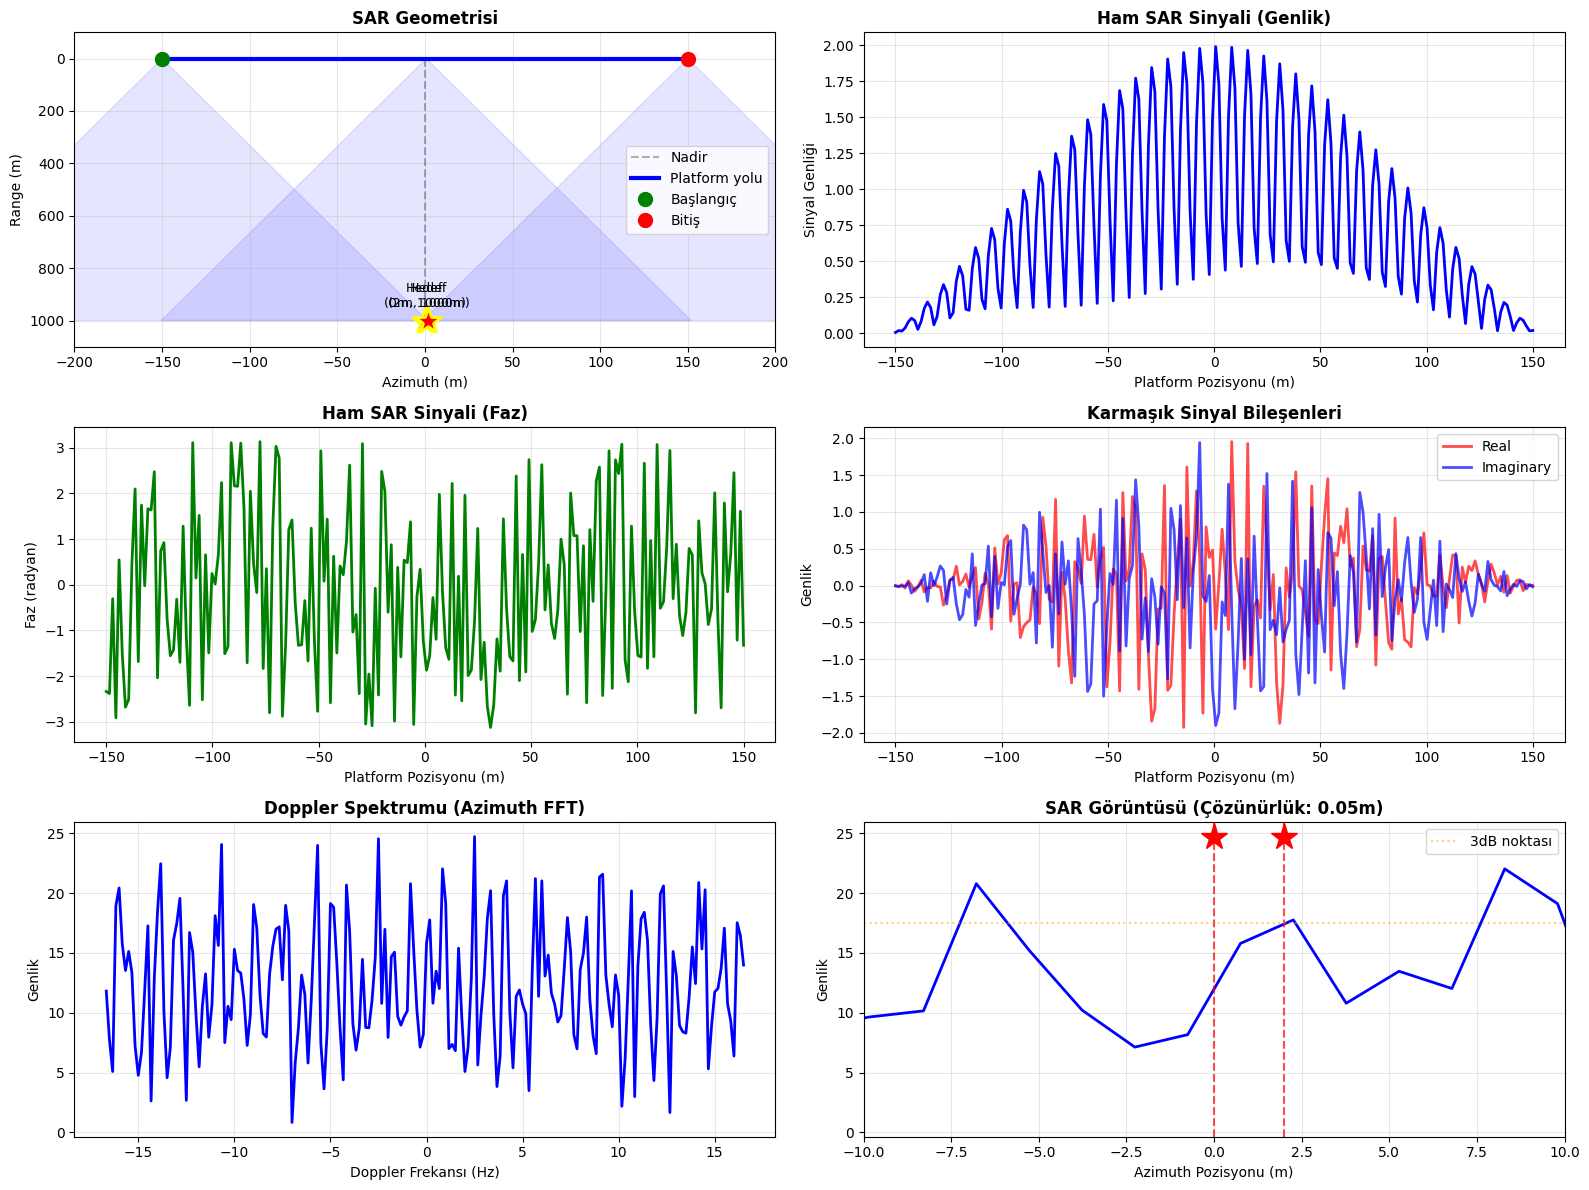


SAR SİMÜLASYON SONUÇLARI:
Fiziksel anten: 0.1 m
Platform hızı: 50 m/s
Hedef mesafesi: 1000 m
Sentetik aperture uzunluğu: 300.0 m
Işın genişliği: 17.19°

ÇÖZÜNÜRLÜK KARŞILAŞTIRMASI:
  Geleneksel radar: 300.0 m (KÖTÜ)
  SAR: 0.05 m (MÜKEMMEL)
  İyileşme: 6000x

HEDEFLER ARASINDAKİ MESAFE: 2 m
SAR ile ayrılabilir mi? EVET ✓


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parametreler
c = 3e8
f_c = 10e9  # 10 GHz
lambda_c = c / f_c  # 3 cm
D_physical = 0.1  # 10 cm fiziksel anten

# Platform
v = 50  # 50 m/s hız
R_target = 1000  # Hedef mesafesi

# Işın genişliği (beamwidth)
beamwidth = lambda_c / D_physical  # radyan
print(f"Fiziksel anten boyutu: {D_physical} m")
print(f"Işın genişliği: {np.rad2deg(beamwidth):.2f}°")

# Sentetik aperture uzunluğu
L_syn = R_target * beamwidth
print(f"Sentetik aperture uzunluğu: {L_syn:.1f} m")

# SAR çözünürlüğü
resolution_SAR = D_physical / 2
print(f"SAR çözünürlüğü: {resolution_SAR:.2f} m")

# Geleneksel radar çözünürlüğü (karşılaştırma için)
resolution_RAR = R_target * beamwidth
print(f"Geleneksel radar çözünürlüğü: {resolution_RAR:.1f} m")
print(f"İyileşme faktörü: {resolution_RAR / resolution_SAR:.0f}x")

# Platform pozisyonları (sentetik aperture boyunca)
n_positions = 200
y_platform = np.linspace(-L_syn/2, L_syn/2, n_positions)

# İki hedef (yan yana)
targets = [
    {'x': 0, 'r': R_target},      # Hedef 1 (merkez)
    {'x': 2, 'r': R_target},      # Hedef 2 (2m sağda)
]

# Her pozisyon için sinyal toplama
raw_signal = np.zeros(n_positions, dtype=complex)

for target in targets:
    for i, y_p in enumerate(y_platform):
        # Platform ile hedef arası mesafe
        R = np.sqrt((y_p - target['x'])**2 + target['r']**2)
        
        # Faz
        phase = (4 * np.pi / lambda_c) * R
        
        # Işın paterni (ağırlıklandırma)
        angle = np.arctan((y_p - target['x']) / target['r'])
        beam_pattern = np.sinc(angle / beamwidth * 2)
        
        # Sinyal
        raw_signal[i] += beam_pattern * np.exp(1j * phase)

# Görselleştirme
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Platform hareketi
ax = axes[0, 0]
ax.plot([0, 0], [0, R_target], 'k--', alpha=0.3, label='Nadir')
for target in targets:
    ax.plot(target['x'], target['r'], 'r*', markersize=20, 
            markeredgewidth=2, markeredgecolor='yellow')
    ax.text(target['x'], target['r']-50, f"Hedef\n({target['x']}m, {target['r']}m)", 
            ha='center', fontsize=9)

# Platform yolu
ax.plot(y_platform, [0]*len(y_platform), 'b-', linewidth=3, label='Platform yolu')
ax.plot(y_platform[0], 0, 'go', markersize=10, label='Başlangıç')
ax.plot(y_platform[-1], 0, 'ro', markersize=10, label='Bitiş')

# Işın genişliği göster (birkaç pozisyon için)
for idx in [0, n_positions//2, n_positions-1]:
    y_p = y_platform[idx]
    angle_range = beamwidth / 2
    x_left = y_p - R_target * np.tan(angle_range)
    x_right = y_p + R_target * np.tan(angle_range)
    ax.fill([y_p, x_left, x_right], [0, R_target, R_target], 
            alpha=0.1, color='blue')

ax.set_xlabel('Azimuth (m)')
ax.set_ylabel('Range (m)')
ax.set_title('SAR Geometrisi', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([R_target+100, -100])
ax.set_xlim([y_platform[0]-50, y_platform[-1]+50])

# 2. Ham sinyal (genlik)
ax = axes[0, 1]
ax.plot(y_platform, np.abs(raw_signal), 'b-', linewidth=2)
ax.set_xlabel('Platform Pozisyonu (m)')
ax.set_ylabel('Sinyal Genliği')
ax.set_title('Ham SAR Sinyali (Genlik)', fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Ham sinyal (faz)
ax = axes[1, 0]
ax.plot(y_platform, np.angle(raw_signal), 'g-', linewidth=2)
ax.set_xlabel('Platform Pozisyonu (m)')
ax.set_ylabel('Faz (radyan)')
ax.set_title('Ham SAR Sinyali (Faz)', fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Real ve Imaginary kısımlar
ax = axes[1, 1]
ax.plot(y_platform, np.real(raw_signal), 'r-', linewidth=2, label='Real', alpha=0.7)
ax.plot(y_platform, np.imag(raw_signal), 'b-', linewidth=2, label='Imaginary', alpha=0.7)
ax.set_xlabel('Platform Pozisyonu (m)')
ax.set_ylabel('Genlik')
ax.set_title('Karmaşık Sinyal Bileşenleri', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Doppler Spektrumu (Azimuth FFT - SAR işleme!)
doppler_spectrum = np.fft.fftshift(np.fft.fft(raw_signal))
doppler_freq = np.fft.fftshift(np.fft.fftfreq(n_positions, d=(L_syn/n_positions)/v))

ax = axes[2, 0]
ax.plot(doppler_freq, np.abs(doppler_spectrum), 'b-', linewidth=2)
ax.set_xlabel('Doppler Frekansı (Hz)')
ax.set_ylabel('Genlik')
ax.set_title('Doppler Spektrumu (Azimuth FFT)', fontweight='bold')
ax.grid(True, alpha=0.3)

# 6. SAR Görüntüsü (Azimuth sıkıştırma sonrası)
# Azimuth eksenini hesapla
azimuth_axis = np.linspace(-L_syn/2, L_syn/2, n_positions)
sar_image = np.abs(doppler_spectrum)

ax = axes[2, 1]
ax.plot(azimuth_axis, sar_image, 'b-', linewidth=2)

# Gerçek hedef pozisyonlarını işaretle
for target in targets:
    ax.axvline(target['x'], color='r', linestyle='--', alpha=0.7)
    ax.plot(target['x'], max(sar_image), 'r*', markersize=20)

ax.set_xlabel('Azimuth Pozisyonu (m)')
ax.set_ylabel('Genlik')
ax.set_title(f'SAR Görüntüsü (Çözünürlük: {resolution_SAR:.2f}m)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([-10, 10])

# 3dB genişlik ölçümü
peak_val = max(sar_image)
half_power = peak_val / np.sqrt(2)
ax.axhline(half_power, color='orange', linestyle=':', alpha=0.5, label='3dB noktası')
ax.legend()

plt.tight_layout()
plt.show()

# Sonuçlar
print("\n" + "="*70)
print("SAR SİMÜLASYON SONUÇLARI:")
print("="*70)
print(f"Fiziksel anten: {D_physical} m")
print(f"Platform hızı: {v} m/s")
print(f"Hedef mesafesi: {R_target} m")
print(f"Sentetik aperture uzunluğu: {L_syn:.1f} m")
print(f"Işın genişliği: {np.rad2deg(beamwidth):.2f}°")
print(f"\nÇÖZÜNÜRLÜK KARŞILAŞTIRMASI:")
print(f"  Geleneksel radar: {resolution_RAR:.1f} m (KÖTÜ)")
print(f"  SAR: {resolution_SAR:.2f} m (MÜKEMMEL)")
print(f"  İyileşme: {resolution_RAR / resolution_SAR:.0f}x")
print(f"\nHEDEFLER ARASINDAKİ MESAFE: 2 m")
print(f"SAR ile ayrılabilir mi? {'EVET ✓' if 2 > resolution_SAR else 'HAYIR ✗'}")
print("="*70)